# **Task Overview**
> **Objective:** Build a machine learning model to predict customer churn using historical data.

### **Deliverables:**

• Exploratory Data Analysis (EDA)

• Feature engineering

• Train/test split and model selection (Logistic Regression, XGBoost, etc.)

• Performance metrics (confusion matrix, AUC-ROC)

• Final report with visualizations


### **Mock Data (Python):**

In [1]:
import pandas as pd

import numpy as np



np.random.seed(42)

n = 10000

data = pd.DataFrame({

  'CustomerID': np.arange(n),

  'Gender': np.random.choice(['Male', 'Female'], size=n),

  'SeniorCitizen': np.random.choice([0, 1], size=n),

  'Tenure': np.random.randint(1, 72, size=n),

  'MonthlyCharges': np.round(np.random.uniform(20, 120, size=n), 2),

  'TotalCharges': lambda df: df['Tenure'] * df['MonthlyCharges'],

  'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], size=n),

  'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], size=n),

  'Churn': np.random.choice([0, 1], size=n, p=[0.73, 0.27])

})

data['TotalCharges'] = (data['Tenure'] * data['MonthlyCharges']).round(2)

In [29]:
import warnings
from pandas.errors import DtypeWarning, ParserWarning

# Capture/ignore import warnings related to encoding, dtype coercion, and date parsing
warnings.filterwarnings('ignore', '.*encoding.*')
warnings.filterwarnings('ignore', category=DtypeWarning)
warnings.filterwarnings('ignore', category=ParserWarning)

# Data Dictionary
This project uses a synthetic customer churn dataset. Below is a data dictionary describing each variable, its type, and expected values.

| Column Name    | Description                                      | Unit         | Expected Range         | Type         | Tag           |
|----------------|--------------------------------------------------|--------------|-----------------------|--------------|---------------|
| CustomerID     | Unique customer identifier                       | N/A          | 0 - 9999              | int          | identifier    |
| Gender         | Customer gender                                  | N/A          | Male, Female          | str          | categorical   |
| SeniorCitizen  | Whether the customer is a senior citizen         | 0 = No, 1 = Yes | 0, 1                | int          | ordinal       |
| Tenure         | Number of months the customer has stayed         | months       | 1 - 72                | int          | numerical     |
| MonthlyCharges | Monthly billing amount                           | USD          | 20.00 - 120.00        | float        | numerical     |
| TotalCharges   | Total amount charged to the customer             | USD          | 20.00 - 8640.00       | float        | numerical     |
| Contract       | Type of contract                                 | N/A          | Month-to-month, One year, Two year | str | categorical   |
| PaymentMethod  | Customer's payment method                        | N/A          | Electronic check, Mailed check, Bank transfer, Credit card | str | categorical   |
| Churn          | Whether the customer left (target variable)      | 0 = No, 1 = Yes | 0, 1                | int          | ordinal       |

- **numerical**: Quantitative variable (continuous or discrete)
- **categorical**: Qualitative variable (unordered)
- **ordinal**: Qualitative variable (ordered)
- **identifier**: Unique key

In [10]:
data.head()

,CustomerID,Gender,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn
0,0,Male,0,55,111.88,6153.40,Two year,Mailed check,0
1,1,Female,1,36,58.70,2113.20,Two year,Electronic check,0
2,2,Male,0,37,118.86,4397.82,One year,Electronic check,0
3,3,Male,1,14,96.14,1345.96,Month-to-month,Mailed check,1
4,4,Male,1,27,28.05,757.35,Two year,Mailed check,0


In [28]:
data['CustomerID'].nunique() == len(data)

True

In [6]:
# Display basic information about the dataset
print("Dataset shape:", data.shape)

print("Data types:\n", data.dtypes.value_counts())


Dataset shape: (10000, 9)
Data types:
 int64      4
object     3
float64    2
Name: count, dtype: int64


In [7]:
# Display descriptive statistics
print("\nDescriptive statistics:")
display(data.describe(include="all").T)


Descriptive statistics:


,CustomerID,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Churn
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.499300,35.955000,70.451038,2541.807390,0.267000
std,2886.89568,0.500025,20.501761,28.935692,1879.645307,0.442414
min,0.00000,0.000000,1.000000,20.000000,21.200000,0.000000
25%,2499.75000,0.000000,18.000000,45.527500,1035.057500,0.000000
50%,4999.50000,0.000000,36.000000,70.585000,2117.135000,0.000000
75%,7499.25000,1.000000,54.000000,95.612500,3717.352500,1.000000
max,9999.00000,1.000000,71.000000,120.000000,8384.390000,1.000000


In [13]:
data.isna().mean().sort_values(ascending=False)  # top 15 missing-value columns

CustomerID        0.0
Gender            0.0
SeniorCitizen     0.0
Tenure            0.0
MonthlyCharges    0.0
TotalCharges      0.0
Contract          0.0
PaymentMethod     0.0
Churn             0.0
dtype: float64

In [8]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
CustomerID        0
Gender            0
SeniorCitizen     0
Tenure            0
MonthlyCharges    0
TotalCharges      0
Contract          0
PaymentMethod     0
Churn             0
dtype: int64


In [9]:
# Explore the target variable distribution
print("\nChurn distribution:")
churn_counts = data['Churn'].value_counts(normalize=True) * 100
print(churn_counts.to_frame().rename(columns={'Churn': 'Percentage (%)'}))


Churn distribution:
       proportion
Churn            
0            73.3
1            26.7


In [14]:
data.duplicated().sum()

np.int64(0)

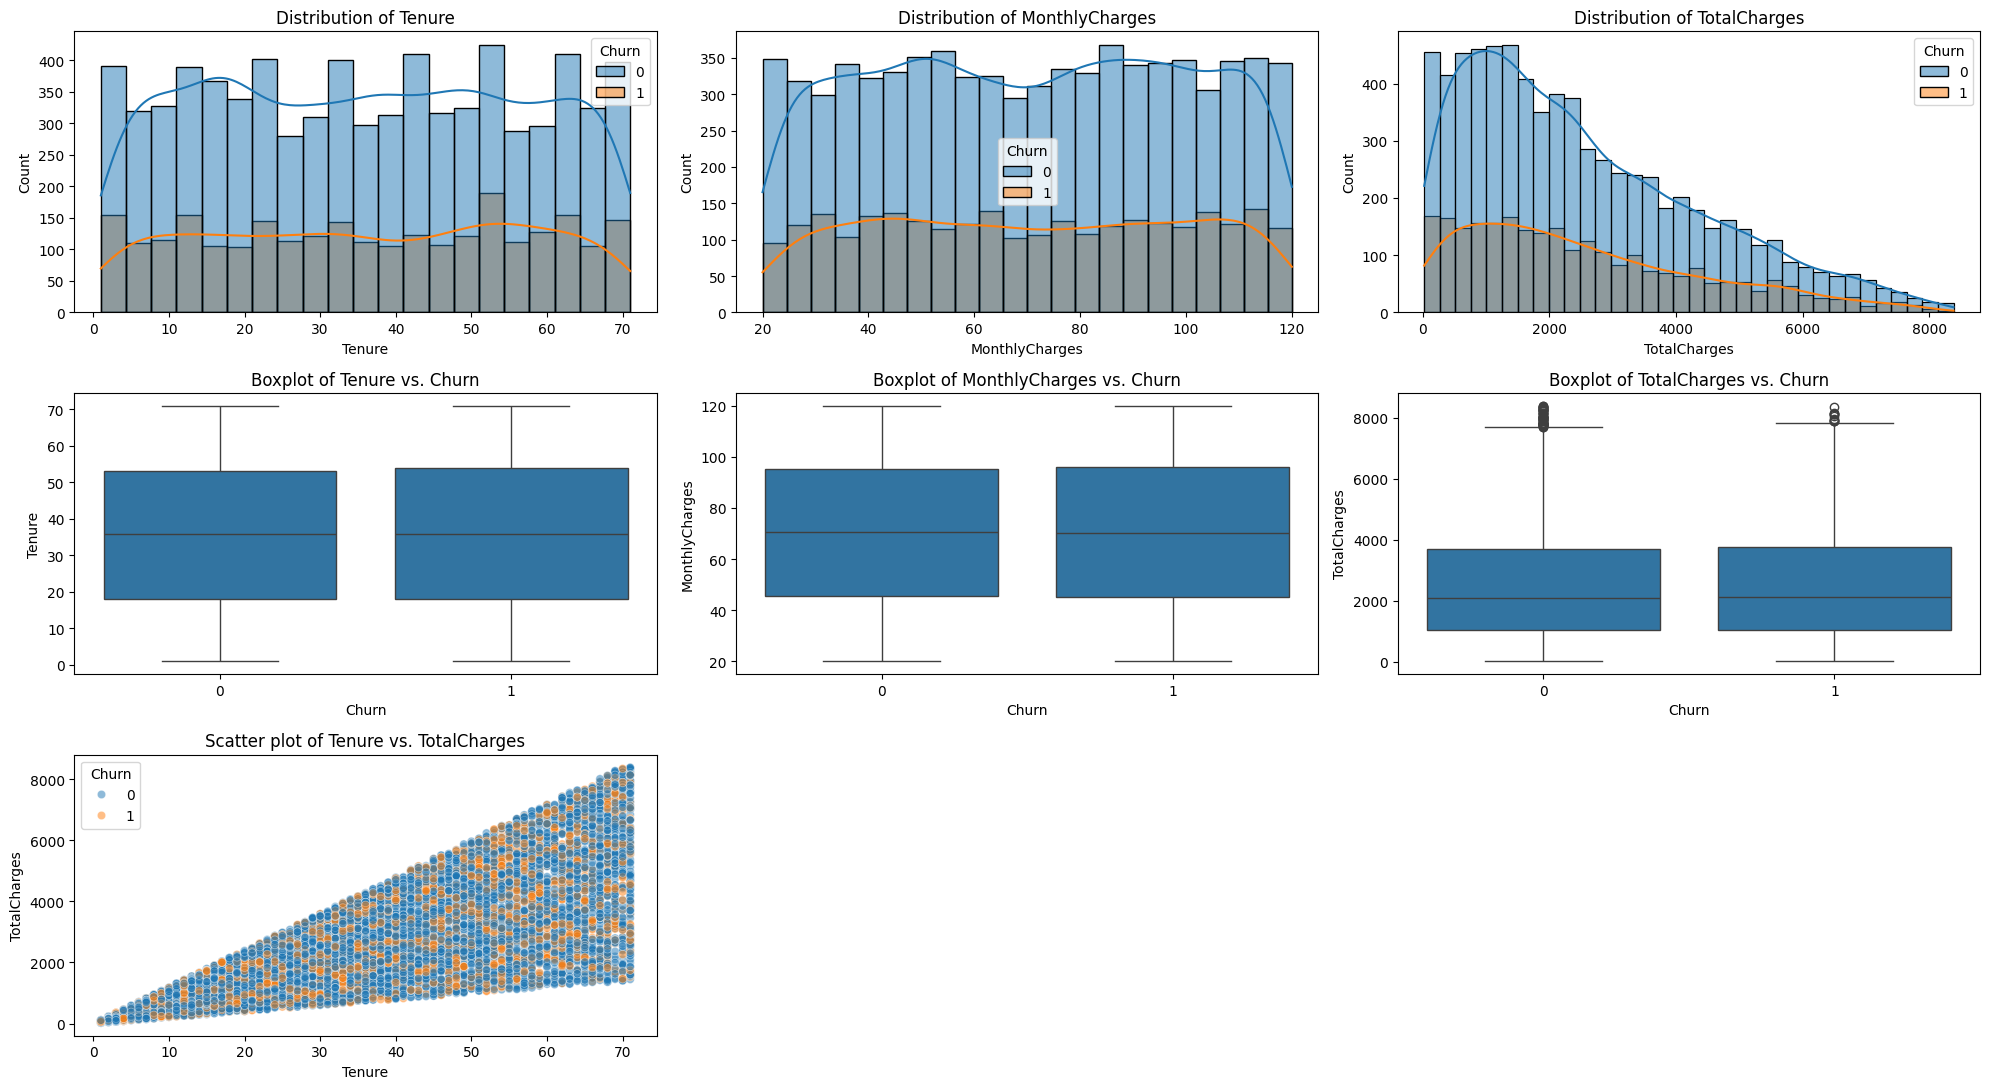

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt

# Visualize the distribution of numerical features
numerical_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(20, 11))

# Histograms
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=data, x=feature, hue='Churn', kde=True)
    plt.title(f'Distribution of {feature}')

# Box plots
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 4)
    sns.boxplot(data=data, y=feature, x='Churn')
    plt.title(f'Boxplot of {feature} vs. Churn')

# Scatter plot (Tenure vs. TotalCharges)
plt.subplot(3, 3, 7)
sns.scatterplot(data=data, x='Tenure', y='TotalCharges', hue='Churn', alpha=0.5)
plt.title('Scatter plot of Tenure vs. TotalCharges')

plt.tight_layout()
plt.show()

In [20]:
# Identify columns with a single unique value (uninformative features)
single_level_cols = [col for col in data.columns if data[col].nunique() == 1]
print("Columns with a single unique value:", single_level_cols)

Columns with a single unique value: []


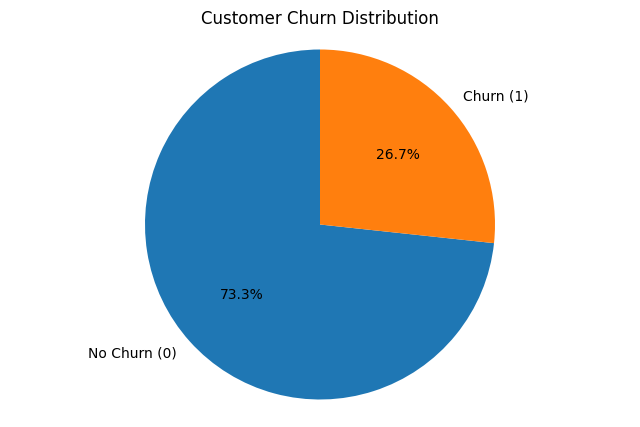

In [11]:
# Visualize the churn distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.pie(churn_counts, labels=['No Churn (0)', 'Churn (1)'], autopct='%1.1f%%', startangle=90)
plt.title('Customer Churn Distribution')
plt.axis('equal')
plt.show()

In [21]:
from scipy.stats import zscore

In [22]:
# Z-score method for outlier detection
z_scores = np.abs(zscore(data[numerical_features]))
outliers_zscore = (z_scores > 3).any(axis=1)# Log-scale histograms for numerical features
plt.figure(figsize=(18, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(np.log1p(data[feature]), kde=True)
    plt.title(f'Log-Scale Histogram of {feature}')
plt.tight_layout()
plt.show()
print(f"Number of outliers detected by Z-score (>3): {outliers_zscore.sum()}")

Number of outliers detected by Z-score (>3): 16


In [25]:
from plotly.subplots import make_subplots

import plotly.graph_objects as go

# Prepare a color list based on the Z-score outlier mask
colors = ['red' if is_outlier else 'gray' for is_outlier in outliers_zscore]

# Create a 1x3 subplot figure
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=[f"{feat} (outliers in red)" for feat in numerical_features]
)

# Add a scatter trace for each numerical feature
for idx, feature in enumerate(numerical_features, start=1):
    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=data[feature],
            mode='markers',
            marker=dict(color=colors, opacity=0.6)
        ),
        row=1,
        col=idx
    )
    fig.update_xaxes(title_text="Index", row=1, col=idx)
    fig.update_yaxes(title_text=feature, row=1, col=idx)

# Adjust layout and display
fig.update_layout(
    height=600,
    width=1600,
    showlegend=False,
    title_text="Z-score Outlier Visualization"
)
fig.show()

In [26]:
# IQR method for outlier detection
outliers_iqr = pd.Series(False, index=data.index)
for feature in numerical_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))
    outliers_iqr = outliers_iqr | mask
print(f"Number of outliers detected by IQR: {outliers_iqr.sum()}")

Number of outliers detected by IQR: 62


In [27]:
# Prepare a color list based on the IQR outlier mask
colors_iqr = ['red' if is_outlier else 'gray' for is_outlier in outliers_iqr]

# Create a 1x3 subplot figure
fig_iqr = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=[f"{feat} (outliers in red)" for feat in numerical_features]
)

# Add a scatter trace for each numerical feature
for idx, feature in enumerate(numerical_features, start=1):
    fig_iqr.add_trace(
        go.Scatter(
            x=data.index,
            y=data[feature],
            mode='markers',
            marker=dict(color=colors_iqr, opacity=0.6)
        ),
        row=1,
        col=idx
    )
    fig_iqr.update_xaxes(title_text="Index", row=1, col=idx)
    fig_iqr.update_yaxes(title_text=feature, row=1, col=idx)

# Adjust layout and display
fig_iqr.update_layout(
    height=600,
    width=1600,
    showlegend=False,
    title_text="IQR Outlier Visualization"
)
fig_iqr.show()